# CAPSTONE
## Company: Computing Vision
The company has seen other big movie companies create original films, and they want to get in on the fun. They have decided to create a new movie studio to create original films.

Computing Vision does not have much experience in original film creation.

- Goal: Provide three business recommendations derived from analyzing several datasets of current box office movies.

> Notebook flow: This jupyter notebook goes as follows, stating each business recomendation with the appropriate code, and conclusions.

## Data Cleaning and merging dataframes

In this notebook, we'll work with `movie_basics` and `movie_ratings` tables from `'im.db'`. As well as `'tn.movie_budget.csv'`.

Before we can get going, we'll need to import the relevant packages and conncet to the database.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
%matplotlib inline
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr
from scipy import stats
import sqlite3
conn = sqlite3.connect('im.db')

In this notebook we'll focus on the `movie_basics` and `movie_ratings`.

## Compared to the Individual Tables:

### `movie_basics` Table:

In [2]:
q = """
SELECT *
FROM movie_basics
"""
pd.read_sql(q, conn).head(5)

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"


### `movie_ratings` Table:

In [3]:
q = """
SELECT *
FROM movie_ratings
"""
pd.read_sql(q, conn).head(5)

,movie_id,averagerating,numvotes
0,tt10356526,8.3,31
1,tt10384606,8.9,559
2,tt1042974,6.4,20
3,tt1043726,4.2,50352
4,tt1060240,6.5,21


## Displaying movie_basics Along with movie_ratings

Since we need to generate a table that includes details about ` movie_basics`  and ` movie_ratings`, we would need to take data from multiple tables in a single statement using a concise way to join the tables, the `USING` clause. Which in this case is `movie_id`. Again, this only works if the column is **identically named** for both tables.

Then we assign the result of the querry to a variable names `df`, which is a dataframe. 

In [4]:
q = """
SELECT
    movie_id, 
    primary_title,
    genres,
    averagerating,
    numvotes
FROM movie_basics
JOIN movie_ratings
    USING (movie_id)
"""
df = pd.read_sql(q, conn)

To get a concise summary of the dataframe, you can use `.info()`: 

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73856 entries, 0 to 73855
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   movie_id       73856 non-null  object 
 1   primary_title  73856 non-null  object 
 2   genres         73052 non-null  object 
 3   averagerating  73856 non-null  float64
 4   numvotes       73856 non-null  int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 2.8+ MB


## Nan (Not a Number):
When working with datasets, it is common to have missing or `NaN (Not a Number)` values. In order to understand the extent of missing data in a dataset, you can use the `.isna()` method to identify where the `NaN` values are located. Taking the `.sum()` of the `.isna(`) method will return the total number of NaN values in the dataset broken down by column.

In [6]:
df.isna().sum()

movie_id           0
primary_title      0
genres           804
averagerating      0
numvotes           0
dtype: int64

Since the `'genre'` is a categorical data and the missing values accounts for only 1 % of our data we decided to drop the rows that contained null values using the built-in function `.dropna()`. Since we are creating a new df, a new name will be given to it as `df_nonull_genres`.

In [7]:
df_nonull_genres = df.dropna(axis = 0)

Lets print the shape of our new df. Next, display the total number of `NaN` values in the dataset broken down by column.

In [8]:
df_nonull_genres.shape

(73052, 5)

In [9]:
df_nonull_genres.isna().sum()

movie_id         0
primary_title    0
genres           0
averagerating    0
numvotes         0
dtype: int64

Since, we dont have any other missing data to deal with, lets focus on finding duplicate movie titles using `.dulpicated()` and `.value_counts()`. Lets display the total amount of dulpicated rows. Subsequently, break it down by frequency for each movie title. 

In [10]:
df_nonull_genres['primary_title'].duplicated().value_counts()

False    69248
True      3804
Name: primary_title, dtype: int64

In [11]:
df_nonull_genres[df_nonull_genres['primary_title'].duplicated()]['primary_title'].value_counts()

The Return           10
Broken                9
Lucky                 8
Homecoming            8
Together              8
                     ..
Checkmate             1
Won't Back Down       1
Political Animals     1
Dead Awake            1
Drømmeland            1
Name: primary_title, Length: 2705, dtype: int64

The df shows 69248 `non-duplicated` values. A common practice would be to handle them properly but for  scope purposes of our study, which means we are time-limited,  lets just keep them in mind. Then, lets take a look on the second dataframe.

The second `df` can be found on `'tn.movie_budget.csv'`. Now, let's get started by reading in the data  and storing it the DataFrame `movie_budget`. Afterwárds, lets preview the data.

In [12]:
movie_budget = pd.read_csv('tn.movie_budgets.csv')
movie_budget.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,18-Dec-09,Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,20-May-11,Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,7-Jun-19,Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,1-May-15,Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,15-Dec-17,Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


`production_budget`, `domestic_gross`, and `worldwide_gross` are strings, so we will remove the commas and dollar signs

In [13]:
movie_budget['production_budget'] = movie_budget['production_budget'].str.replace('$', '').str.replace(',', '')
movie_budget['domestic_gross'] = movie_budget['domestic_gross'].str.replace('$', '').str.replace(',', '')
movie_budget['worldwide_gross'] = movie_budget['worldwide_gross'].str.replace('$', '').str.replace(',', '')

C:\Users\raguilarsoriano\AppData\Local\Temp\ipykernel_18552\3322509581.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  movie_budget['production_budget'] = movie_budget['production_budget'].str.replace('$', '').str.replace(',', '')
C:\Users\raguilarsoriano\AppData\Local\Temp\ipykernel_18552\3322509581.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  movie_budget['domestic_gross'] = movie_budget['domestic_gross'].str.replace('$', '').str.replace(',', '')
C:\Users\raguilarsoriano\AppData\Local\Temp\ipykernel_18552\3322509581.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions

`production_budget`, `domestic_gross`, and `worldwide_gross` are still strings, so we will change them to integers to be able to perform calculations with those columns

In [14]:
movie_budget['production_budget'] = movie_budget['production_budget'].astype('int64')
movie_budget['domestic_gross'] = movie_budget['domestic_gross'].astype('int64')
movie_budget['worldwide_gross'] = movie_budget['worldwide_gross'].astype('int64')

A concise summary will be provided using `.info()`.

In [15]:
movie_budget.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   int64 
 4   domestic_gross     5782 non-null   int64 
 5   worldwide_gross    5782 non-null   int64 
dtypes: int64(4), object(2)
memory usage: 271.2+ KB


The above summary contains also the amount of null values brake down by columns. Since we don´t have missing data to deal with, we can move into merging `movie_budget`df and `df_nonull_genres` df. 

For doing so, lets print a short preview for both Dataframes. Focus on the column names.

In [16]:
df_nonull_genres.head(2)

,movie_id,primary_title,genres,averagerating,numvotes
0,tt0063540,Sunghursh,"Action,Crime,Drama",7.0,77
1,tt0066787,One Day Before the Rainy Season,"Biography,Drama",7.2,43


`movie_budget` df:

In [17]:
movie_budget.head(2)

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,18-Dec-09,Avatar,425000000,760507625,2776345279
1,2,20-May-11,Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875


As you can see, the column which displays the movie title is different in both Dataframes. `df_nonull_genres` uses `'primary_title'`while `movie_budget` uses `'movie'`. 

We need to set them equal to use the column name as a key for merging both Dataframes into one. Will set both columns names as `'movie'`. In this case,  `df_nonull_genres` is the one selected to change its column name. 

In [18]:
df_nonull_genres.rename(columns={'primary_title' : 'movie'}, inplace = True)

C:\Users\raguilarsoriano\AppData\Local\Temp\ipykernel_18552\3490391291.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nonull_genres.rename(columns={'primary_title' : 'movie'}, inplace = True)


Lets view the column labels of the DataFrame `df_nonull_genres`.

In [19]:
df_nonull_genres.columns

Index(['movie_id', 'movie', 'genres', 'averagerating', 'numvotes'], dtype='object')

As you see, now the column name was changed succesfully. 

## Nan (Not a Number):

The following line of code is performing a merge operation between  `df_nonull_genre`s and `movie_budget`.

The merge is performed based on a common column called `'movie'`, specified by the `on` parameter.

The type of merge used is specified by the how parameter, which in this case is set to `'left'`, meaning that all the rows from the `df_nonull_genres dataframe` will be kept and any matching rows from the `movie_budget` dataframe will be included. Any non-matching rows from the movie_budget dataframe will have null values in the resulting dataframe.

Finally, a new column called `'im_and_movie_budget'` is added to the resulting merged dataframe, indicating whether a row is present in both dataframes (i.e., 'both'), only in the left dataframe (i.e., 'left_only'), or only in the right dataframe (i.e., 'right_only'). This is specified by the `indicator` parameter.

The resulting dataframe is assigned to the variable `im_movie_budget`. Subsequently, we use `value_counts()` to return a new Series object with the count of unique values of the new column called `'im_and_movie_budget'`.

In [20]:
im_movie_budget = pd.merge(df_nonull_genres ,movie_budget, on='movie', how='left', indicator = 'im_and_movie_budget')
im_movie_budget['im_and_movie_budget'].value_counts()

left_only     70307
both           2867
right_only        0
Name: im_and_movie_budget, dtype: int64

A sample was taken from Dataframe `im_movie_budget` by selecting rows that has a string value equal to `both`on column `'im_and_movie_budget'`. That sample name is `cleaned_df`.

In [21]:
cleaned_df = im_movie_budget[im_movie_budget['im_and_movie_budget'] == 'both'] 
cleaned_df.head(4)

,movie_id,movie,genres,averagerating,numvotes,id,release_date,production_budget,domestic_gross,worldwide_gross,im_and_movie_budget
16,tt0249516,Foodfight!,"Action,Animation,Comedy",1.9,8248,26.0,31-Dec-12,45000000.0,0.0,73706.0,both
36,tt0337692,On the Road,"Adventure,Drama,Romance",6.1,37886,17.0,22-Mar-13,25000000.0,720828.0,9313302.0,both
42,tt0359950,The Secret Life of Walter Mitty,"Adventure,Comedy,Drama",7.3,275300,37.0,25-Dec-13,91000000.0,58236838.0,187861183.0,both
46,tt0365907,A Walk Among the Tombstones,"Action,Crime,Drama",6.5,105116,67.0,19-Sep-14,28000000.0,26017685.0,62108587.0,both


Lets get a concise summary of the dataframe using `.info()`: 

In [22]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2867 entries, 16 to 73164
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   movie_id             2867 non-null   object  
 1   movie                2867 non-null   object  
 2   genres               2867 non-null   object  
 3   averagerating        2867 non-null   float64 
 4   numvotes             2867 non-null   int64   
 5   id                   2867 non-null   float64 
 6   release_date         2867 non-null   object  
 7   production_budget    2867 non-null   float64 
 8   domestic_gross       2867 non-null   float64 
 9   worldwide_gross      2867 non-null   float64 
 10  im_and_movie_budget  2867 non-null   category
dtypes: category(1), float64(5), int64(1), object(4)
memory usage: 249.3+ KB


floats data types
it's possible for columns with integer data types to be converted to floating point data types. This can happen if one of the dataframes has null or missing values in the column being merged.

To avoid this type conversion, you can either fill in the missing values before merging the dataframes or use the astype method to convert the column back to an integer after the merge.

In [23]:
cleaned_df['production_budget'] = cleaned_df['production_budget'].astype('int64')
cleaned_df['domestic_gross'] = cleaned_df['domestic_gross'].astype('int64')
cleaned_df['worldwide_gross'] = cleaned_df['worldwide_gross'].astype('int64')

C:\Users\raguilarsoriano\AppData\Local\Temp\ipykernel_18552\2674449468.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df['production_budget'] = cleaned_df['production_budget'].astype('int64')
C:\Users\raguilarsoriano\AppData\Local\Temp\ipykernel_18552\2674449468.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df['domestic_gross'] = cleaned_df['domestic_gross'].astype('int64')
C:\Users\raguilarsoriano\AppData\Local\Temp\ipykernel_18552\2674449468.py:3: SettingWithCopyWarning: 
A valu

Added net revenue by movie

In [24]:
cleaned_df['worlwide_net_revenue'] = cleaned_df['worldwide_gross'] - cleaned_df['production_budget']
cleaned_df[['production_budget', 'worldwide_gross', 'worlwide_net_revenue']]

C:\Users\raguilarsoriano\AppData\Local\Temp\ipykernel_18552\1701568743.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df['worlwide_net_revenue'] = cleaned_df['worldwide_gross'] - cleaned_df['production_budget']


,production_budget,worldwide_gross,worlwide_net_revenue
16,45000000,73706,-44926294
36,25000000,9313302,-15686698
42,91000000,187861183,96861183
46,28000000,62108587,34108587
47,215000000,1648854864,1433854864
...,...,...,...
72971,47000000,116773317,69773317
73096,30000000,106030660,76030660
73111,109000000,87683966,-21316034
73151,700000,1110511,410511


At this point, we are all set to begin with the Eploratory Data Analisis.

# Business Case 2: Difference in budget by genres

In this business case, we want to know if higher the `production_budget` the higher the `worlwide_net_revenue`. 

To test this hypothesis, we would need to conduct regression analysis, to examine the strength and direction of the relationship between these two variables. First for the whole population and then across genres. 

Befor jumping into the complex part, lets define a function named `stats` to define the `mean`, `median`, and `standard deviation` of a given column of the dataframe to better understand the distribution of some variables/columns.

In [32]:
def stats(column):
    """
    This function takes the name of a column as inputs, and returns its mean, median and standard
    deviation. 
    
    Args: 
        column_name (str): The name of the column to get their stats. 
        
    Returns: 
        pandas.DataFrame: A new DataFrame with the specified column sorted in descending order. 
    """
    mean = cleaned_df[column].mean()
    median = cleaned_df[column].median()
    std = cleaned_df[column].std()
    return print(f' Mean:{mean}\n Median:{median}\n Std:{std}\n')

We will produce a histogram for `averagerating`

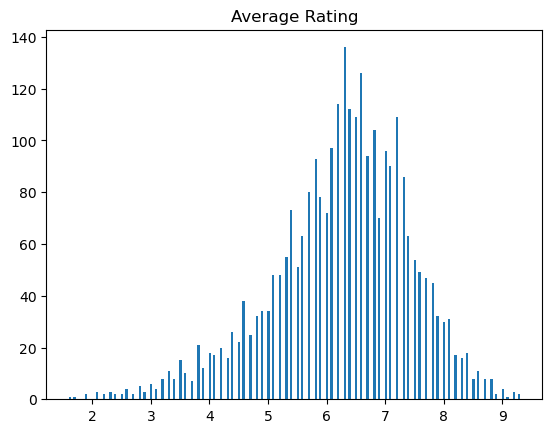

In [33]:
fig, ax = plt.subplots()
plt.hist(cleaned_df["averagerating"], bins=200)
ax.set_title("Average Rating");

We will produce the `stats` function for `averagerating`

In [34]:
stats('averagerating')

 Mean:6.249110568538549
 Median:6.4
 Std:1.1859530886691918



We will produce a histogram for `numvotes`

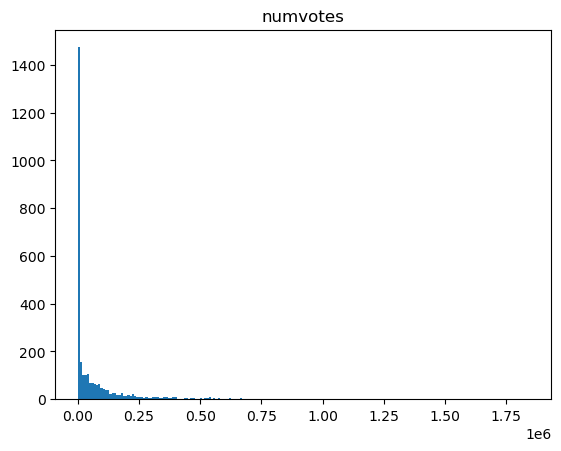

In [35]:
fig, ax = plt.subplots()
plt.hist(cleaned_df["numvotes"], bins=200)
ax.set_title("numvotes");

We will produce the `stats` function for `numvotes`

In [36]:
stats('numvotes')

 Mean:66465.27659574468
 Median:7999.0
 Std:134449.32806695305



We will produce a histogram for `production_budget`

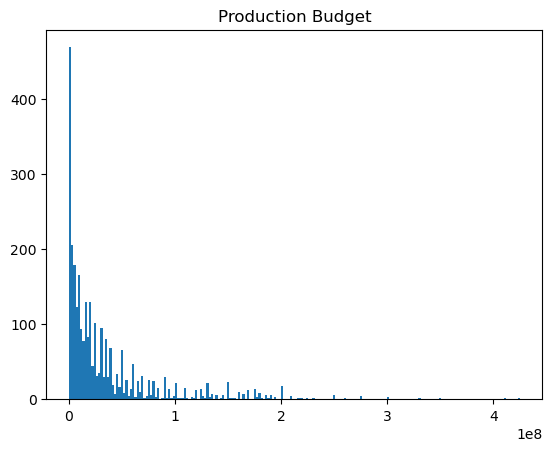

In [37]:
fig, ax = plt.subplots()
plt.hist(cleaned_df["production_budget"], bins=200)
ax.set_title("Production Budget");

We will produce the `stats` function for `production_budget`

In [38]:
stats('production_budget')

 Mean:34287085.19637252
 Median:17000000.0
 Std:47672750.903373405



We will produce a histogram for `worlwide_net_revenue`

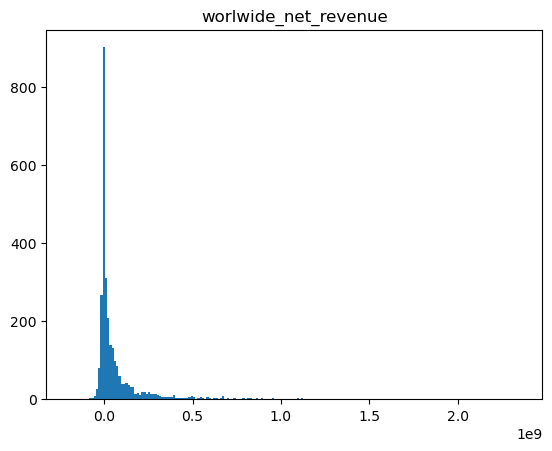

In [39]:
fig, ax = plt.subplots()
plt.hist(cleaned_df["worlwide_net_revenue"], bins=200)
ax.set_title("worlwide_net_revenue");

We will produce the `stats` function for `worlwide_net_revenue`

In [40]:
stats('worlwide_net_revenue')

 Mean:68593345.74363446
 Median:9596747.0
 Std:169464167.71571285



Let's create a new column named `'by_genre'` that performs an individual `COUNT` for each genre. Since some films have multi-categorical genres, we need to break them down into single categories, resulting in the film appearing as many times as the number of genres it has. This will allow us to group the data later by genre using `.GROUPBY()`.

In [41]:
# split values by commas from column genres and explode the column
b2_explode_cleaned_df = cleaned_df.assign(by_genre = cleaned_df['genres'].str.split(',')).explode('by_genre')
b2_explode_cleaned_df.head(6)

,movie_id,movie,genres,averagerating,numvotes,id,release_date,production_budget,domestic_gross,worldwide_gross,im_and_movie_budget,worlwide_net_revenue,by_genre
16,tt0249516,Foodfight!,"Action,Animation,Comedy",1.9,8248,26.0,31-Dec-12,45000000,0,73706,both,-44926294,Action
16,tt0249516,Foodfight!,"Action,Animation,Comedy",1.9,8248,26.0,31-Dec-12,45000000,0,73706,both,-44926294,Animation
16,tt0249516,Foodfight!,"Action,Animation,Comedy",1.9,8248,26.0,31-Dec-12,45000000,0,73706,both,-44926294,Comedy
36,tt0337692,On the Road,"Adventure,Drama,Romance",6.1,37886,17.0,22-Mar-13,25000000,720828,9313302,both,-15686698,Adventure
36,tt0337692,On the Road,"Adventure,Drama,Romance",6.1,37886,17.0,22-Mar-13,25000000,720828,9313302,both,-15686698,Drama
36,tt0337692,On the Road,"Adventure,Drama,Romance",6.1,37886,17.0,22-Mar-13,25000000,720828,9313302,both,-15686698,Romance


In [42]:
# Count appearances of each genre. 
b2_explode_cleaned_df['by_genre'].value_counts()

Drama          1491
Comedy          758
Action          630
Thriller        509
Adventure       448
Crime           362
Horror          360
Romance         326
Mystery         223
Sci-Fi          204
Documentary     204
Biography       195
Fantasy         175
Family          144
Animation       130
Music            72
History          71
Sport            62
War              39
Musical          22
Western          16
News              3
Name: by_genre, dtype: int64

### Finding the population correlation between `production_budget` and `worlwide_net_revenue`.

Lets add the correlation level and the R-squared coefficient. Lets use the regressión line as tendency line just to ilustrate the positive correlation.

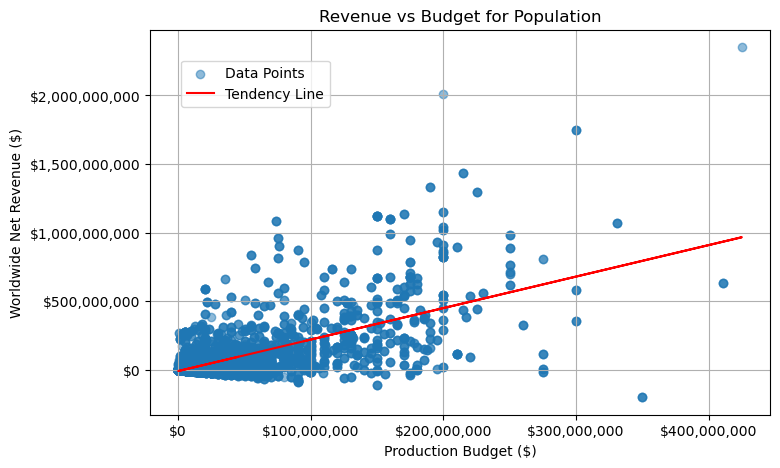

In [43]:
# Fit linear regression model
model = LinearRegression().fit(b2_explode_cleaned_df[['production_budget']], b2_explode_cleaned_df['worlwide_net_revenue'])

# Create scatter plot with regression line
fig, ax = plt.subplots(figsize=(8,5))
ax.scatter(b2_explode_cleaned_df['production_budget'], b2_explode_cleaned_df['worlwide_net_revenue'], alpha=0.5)
ax.plot(b2_explode_cleaned_df['production_budget'], model.predict(b2_explode_cleaned_df[['production_budget']]), color='red')

# Set axis labels and title
ax.set_xlabel('Production Budget ($)')
ax.set_ylabel('Worldwide Net Revenue ($)')
ax.set_title('Revenue vs Budget for Population')

# Add a legend
ax.legend(["Data Points", "Tendency Line"], loc=(.05, .80))

# Add gridlines
ax.grid()

# Format tick labels
ax.get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "${:,.0f}".format(x)))
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "${:,.0f}".format(x)))

# Save and show plot
plt.savefig('plot.png', dpi=300, bbox_inches='tight')
plt.show()

In [44]:
# Imort library again, for some reason the first time was not enough
from scipy import stats

# R-squared coeficient
# calculate the slope, the intercept and the correlation coefficient
slope, intercept, r_value, p_value, std_err = stats.linregress(b2_explode_cleaned_df['production_budget'], b2_explode_cleaned_df['worlwide_net_revenue'])

# calculating the coefficient of determination (R-squared)
r_squared = r_value**2

# print r-squared coeficient
print(f"R-squared coeficient: {r_squared}")

# Pearson Coeficient:
corr_coef, p_value = pearsonr(b2_explode_cleaned_df["production_budget"], b2_explode_cleaned_df["worlwide_net_revenue"])
print(f'Pearson coeficient: {corr_coef}\nThe p-value is: {p_value}')

R-squared coeficient: 0.42798445595949036
Pearson coeficient: 0.6542052093643786
The p-value is: 0.0


The pearson coeficients indicate a moderate-strong postive correlation between` production_budget` and `worlwide_net_revenue`.
The R-squared suggests that less than half of the observed variation of `worlwide_net_revenue` can be explained by `production_budget`. This two points are not conclusive, but gives us an idea that overall there is no reason to believe that the higher the budget the higher the revenue. 

Next steps requires identifying the correlation level across genres and creating a graph to better understand their level.

In [45]:
def get_rsquared_by_genre(df):
    """
    Iterates over the distinct genres in the 'by_genre' column of a pandas DataFrame
    and calculates the R-squared coefficient for each genre using linear regression.
    
    Parameters:
        df (pandas.DataFrame): The DataFrame to iterate over.
        
    Returns:
        A pandas DataFrame with two columns: 'Genre' and 'R-squared', containing the 
        calculated R-squared coefficient for each distinct genre in the 'by_genre' column.
    """
    # get list of distinct genres
    genres = df['by_genre'].unique()
    
    # initialize empty lists to store results
    genre_list = []
    rsquared_list = []
    
    # iterate over genres and calculate R-squared for each
    for genre in genres:
        # subset DataFrame for current genre
        genre_df = df[df['by_genre'] == genre]
        
        # calculate R-squared using linear regression
        slope, intercept, r_value, p_value, std_err = stats.linregress(genre_df['production_budget'], genre_df['worlwide_net_revenue'])
        r_squared = r_value**2
        
        # append results to lists
        genre_list.append(genre)
        rsquared_list.append(r_squared)
    
    # create and return a new DataFrame with results
    result_df = pd.DataFrame({'Genre': genre_list, 'R-squared': rsquared_list}).sort_values(by = 'R-squared', ascending = False)
    return result_df

In [46]:
# Assign function ouput to 'dataframe'
rsquare_df = get_rsquared_by_genre(b2_explode_cleaned_df)

# Change column name from 'Genre' to 'by_genre'
rsquare_df.rename(columns={'Genre' : 'by_genre'}, inplace = True)

# Print df
rsquare_df

,by_genre,R-squared
20,Musical,0.604143
16,Sport,0.522832
10,Horror,0.502762
7,Sci-Fi,0.485556
14,War,0.449724
6,Crime,0.438581
0,Action,0.425931
2,Comedy,0.396817
8,Family,0.387774
9,Thriller,0.384037


In [47]:
# Dataframe containing pearson coeficient by movie genre
b2_corr_table = b2_explode_cleaned_df.groupby('by_genre')[['production_budget', 'worlwide_net_revenue']].corr().iloc[0::2,-1].sort_values(ascending=False).reset_index()

# Drop column name 'level_1'
b2_corr_table.drop(columns = 'level_1', inplace = True)

# Change column name from 'Genre' to 'by_genre'
b2_corr_table.rename(columns={'worlwide_net_revenue' : 'Pearson_coef'}, inplace = True)

# Print df
b2_corr_table

,by_genre,Pearson_coef
0,Musical,0.777266
1,Sport,0.723071
2,Horror,0.709057
3,Sci-Fi,0.696818
4,War,0.670615
5,Crime,0.662254
6,Action,0.652634
7,Comedy,0.629934
8,Family,0.622715
9,Thriller,0.619707


In [48]:
# Merge two dataframes
r_pear_coef_df = pd.merge(b2_corr_table ,rsquare_df, on='by_genre', how='left')
r_pear_coef_df

,by_genre,Pearson_coef,R-squared
0,Musical,0.777266,0.604143
1,Sport,0.723071,0.522832
2,Horror,0.709057,0.502762
3,Sci-Fi,0.696818,0.485556
4,War,0.670615,0.449724
5,Crime,0.662254,0.438581
6,Action,0.652634,0.425931
7,Comedy,0.629934,0.396817
8,Family,0.622715,0.387774
9,Thriller,0.619707,0.384037


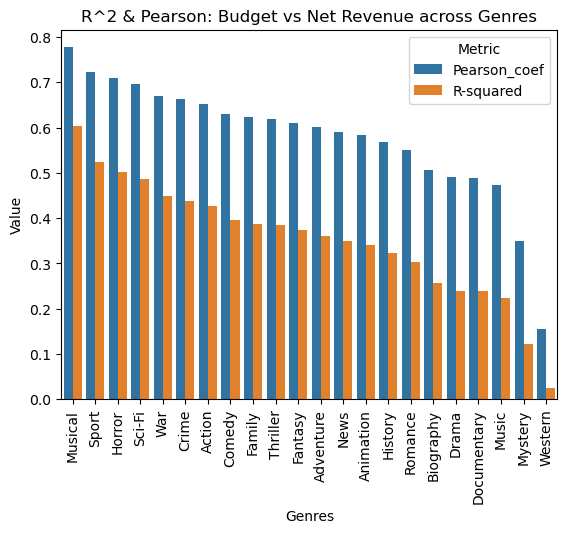

In [49]:
# melt the DataFrame to create a tidy format
df_melt = pd.melt(r_pear_coef_df, id_vars='by_genre', var_name='metric', value_name='value')

# create the bar graph
sns.barplot(x='by_genre', y = 'value', hue = 'metric', data = df_melt)

# add labels and legends to the graph
plt.xlabel('by_genre')
plt.ylabel('Value')
plt.legend(title='Metric', loc='upper right')

# Set axis labels and title
plt.xlabel('Genres')
# plt.ylabel('Correlation')
plt.title('R^2 & Pearson: Budget vs Net Revenue across Genres')

# Rotate xticks 90 degrees
plt.xticks(rotation=90)

# Save and show plot
plt.savefig('plot_corre.png', dpi=300, bbox_inches='tight')
plt.show();

A moderate-strong positive correlation was observed between `production_budget` and `worldwide_net_revenue`. However, this correlation decreases significantly across different genres, indicating that the relationship is not universal. The r-squared coefficient is also significantly lower across genres, indicating that there is not a strong relation between `production_budget` and `worldwide_net_revenue`. This suggests that higher budgets do not translate to higher revenues, neither for the population nor across genres.

## Business Case 2: Conclusion

The conclusion of this business case is that Computer Vision should be carefull when thinking that a bigger budget will translate into higher revenue. So to speak, there is an adequate budget. Unfortunatedly, the data provided does not contain more data that could help us understand what other factors may contribute to high revenue.